In [10]:
import pandas as pd
from re import sub as regex
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import ComplementNB
from nltk.stem import PorterStemmer as Stemmer
from dictionary import dictionary as dictionary
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [11]:
df = pd.read_csv("undersampled_spam.csv", encoding="latin")
df = df.drop(columns=["Unnamed: 0"])
df.sample(5)

,type,sms,processedSMS,filteredSMS
1341,1,Ur TONEXS subscription has been renewed and yo...,ur tonex subscript renew charg 4 50 choos 10 p...,"['ur', 'tonex', 'subscript', 'renew', 'charg',..."
813,1,"UpgrdCentre Orange customer, you may now claim...",upgrdcentr orang custom may claim free camera ...,"['upgrdcentr', 'orang', 'custom', 'may', 'clai..."
162,0,"Ok that would b lovely, if u r sure. Think abo...",ok would b love u r sure think wot u want drin...,"['ok', 'would', 'b', 'love', 'u', 'r', 'sure',..."
65,0,I've reached home finally...,reach home final,"['reach', 'home', 'final']"
653,0,Your brother is a genius,brother geniu,"['brother', 'geniu']"


In [12]:
longest_sms = max([len(sms) for sms in df["filteredSMS"]])
print(longest_sms)

512


In [13]:
def padding_layer(smsList):
    word_to_indices = []
    for sms in smsList:
        sms_indices = []
        if len(sms) < 1:
            word_to_indices.append([dictionary["[empty]"]])
        else:
            for word in sms:
                if any(character.isdigit() for character in word):
                    sms_indices.append(dictionary["[number]"])
                elif word in dictionary:
                    sms_indices.append(dictionary[word])
            word_to_indices.append(sms_indices)
    
    padded_sms = []
    for indices in word_to_indices:
        padding = indices
        for j in range(longest_sms - len(indices)):
            padding.append(0)
        padded_sms.append(padding)
    return padded_sms

df["padded_sms"] = padding_layer(df["filteredSMS"])
df["padded_sms"].sample(5)

1016    [9, 13, 1139, 13, 252, 182, 23, 41, 1048, 2, 1...
936     [1048, 23, 9, 938, 103, 938, 938, 23, 772, 13,...
661     [1048, 9, 119, 1399, 174, 13, 1139, 1048, 103,...
770     [1139, 9, 2, 938, 13, 1399, 9, 938, 1048, 1139...
709     [182, 41, 119, 2576, 1048, 0, 0, 0, 0, 0, 0, 0...
Name: padded_sms, dtype: object

In [14]:
def preprocess(sms):
    # Removes special characters - only letters and numbers remain + lowers text
    sms = regex(r"[^a-zA-Z0-9]", " ", sms.lower())
    # Utilizes NLTK to tokenize text
    sms = word_tokenize(sms)
    # Utilizes removes NLTK stopwords from sms
    sms = [word for word in sms if word not in stopwords.words("english")]
    # Utilizes NLTK Stemmer to stem words
    sms = [Stemmer().stem(word) for word in sms]
    return [sms]

In [15]:
def predict(model, sms, label):
    print(f"Correct: {label} - Prediction - {model.predict(padding_layer(preprocess(sms)))}")

In [16]:
def run(model):
    print(model)

    # Loading Data
    df = pd.read_csv("undersampled_spam.csv", encoding="latin")
    df = df.dropna()

    # Preparing Data
    df["padded_sms"] = padding_layer(df["filteredSMS"])

    # Splitting Data
    features, labels = df["padded_sms"].to_list(), df["type"]
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=2022, stratify=labels)
    x_train, x_val, y_train, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=2022, stratify=y_test)

    # Train Model
    model = model.fit(x_train, y_train)

    # Validate Model
    print("Validation Results:")
    y_pred = model.predict(x_val)
    print(classification_report(y_val, y_pred))

    # Test Model
    print("Testing Results:")
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))

    # More Testing Results
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0)}")
    rc1, rc2, rc3 = precision_recall_curve(y_test, y_pred)
    print(f"PR_AUC: {auc(rc2,  rc1)}")
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1]).plot()
    plt.axis("off")
    plt.show()

    # Test Model on real-life sms
    predict(model, "how is your day going?", 0)
    predict(model, "wanna go to the park?", 0)
    predict(model, "bro, the movie was great! You should watch it too.", 0)
    predict(model, "free $50 amazon gift card reply back now", 1)
    predict(model, "Bank of America closed your bank account. Please confirm your pin at bankofamerica.com/cx1234124r1234vb to keep your account activated", 1)
    predict(model, "You've won a prize! Go to bit.ly/yourprize001 to claim your $500 Amazon gift card", 1)

<p style="text-align: center;">ComplementNB</p>

ComplementNB()
Validation Results:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       112
           1       0.86      0.79      0.82       112

    accuracy                           0.83       224
   macro avg       0.83      0.83      0.83       224
weighted avg       0.83      0.83      0.83       224

Testing Results:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       224
           1       0.89      0.82      0.86       224

    accuracy                           0.86       448
   macro avg       0.86      0.86      0.86       448
weighted avg       0.86      0.86      0.86       448

Accuracy: 0.8616071428571429
Precision: 0.8932038834951457
Recall: 0.8214285714285714
PR_AUC: 0.9019590846047157


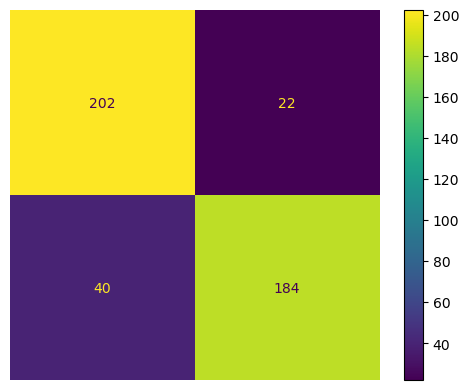

Correct: 0 - Prediction - [0]
Correct: 0 - Prediction - [0]
Correct: 0 - Prediction - [0]
Correct: 1 - Prediction - [0]
Correct: 1 - Prediction - [0]
Correct: 1 - Prediction - [0]


In [17]:
run(ComplementNB())

<p style="text-align: center;">Neural Network</p>

MLPClassifier(max_iter=3000)
Validation Results:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       112
           1       0.83      0.80      0.82       112

    accuracy                           0.82       224
   macro avg       0.82      0.82      0.82       224
weighted avg       0.82      0.82      0.82       224

Testing Results:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       224
           1       0.92      0.90      0.91       224

    accuracy                           0.91       448
   macro avg       0.91      0.91      0.91       448
weighted avg       0.91      0.91      0.91       448

Accuracy: 0.9107142857142857
Precision: 0.9181818181818182
Recall: 0.9017857142857143
PR_AUC: 0.9345373376623377


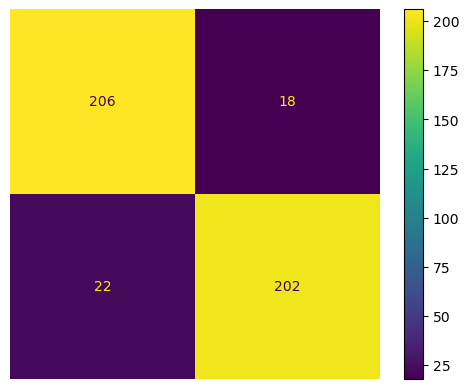

Correct: 0 - Prediction - [0]
Correct: 0 - Prediction - [0]
Correct: 0 - Prediction - [0]
Correct: 1 - Prediction - [0]
Correct: 1 - Prediction - [1]
Correct: 1 - Prediction - [0]


In [18]:
run(MLPClassifier(max_iter=3000))